# Questionnaire Task Performance Analysis

1. Let's conmvert categorical data to numberical (Task success to performance scale)

In [15]:
import pandas as pd

# Define the relative path to the CSV file
file_path = "../../../cleaned_data/questionnaire_df.csv"

# Load the CSV file into a pandas dataframe
df = pd.read_csv(file_path)

# Identify columns that contain "Subtasks success" in their names
subtasks_columns = [col for col in df.columns if "Subtasks success" in col or 'participant_code' in col or "Controller" in col]

# Define the mapping for replacement
replacement_mapping = {
    "Success": 10,
    "Partial Success: Recovered alone from fail": 7,
    "Partial Failure: Small adjustment/help needed": 4,
    "Complete Failure: Give up or big adjustment needed": 0
}

# Apply the mapping to all identified columns
df[subtasks_columns] = df[subtasks_columns].replace(replacement_mapping)


In [17]:
df[subtasks_columns].to_csv("task_performance.csv", index=False)

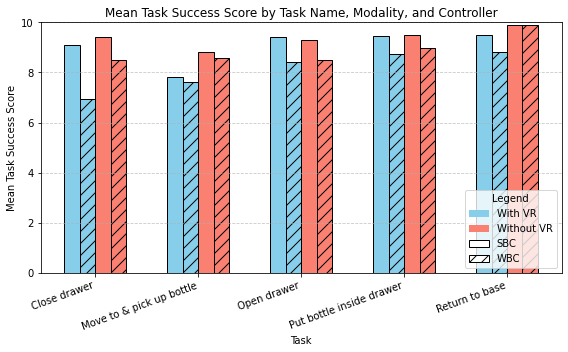

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Extract relevant columns for subtasks success
subtasks_columns = [col for col in df.columns if "Subtasks success" in col]

# Define task names to be extracted from column names
task_names = ["Open drawer", "Move to & pick up bottle", "Put bottle inside drawer", "Close drawer", "Return to base"]

# Create a list to store data for plotting
plot_data = []

# Extract task success values along with modality (WITH-VR or NO-VR), task name, and controller type
for col in subtasks_columns:
    for task in task_names:
        if task in col:
            modality = "WITH-VR" if "WITH-VR" in col else "NO-VR"
            for index, row in df.iterrows():
                controller = row["PERSONAL_Controller being tested?"]
                success_value = row[col]
                if pd.notna(success_value):  # Only consider non-null values
                    plot_data.append((task, modality, controller, success_value))

# Convert to DataFrame for visualization
df_plot = pd.DataFrame(plot_data, columns=["Task", "Modality", "Controller", "Success Score"])

# Calculate the mean success score for each task, modality, and controller
df_mean_plot = df_plot.groupby(["Task", "Modality", "Controller"])["Success Score"].mean().reset_index()
df_mean_plot["Hue"] = df_mean_plot["Modality"] + " - " + df_mean_plot["Controller"]

# Now proceed with visualization
plt.figure(figsize=(8, 5))

# Define colors for WITH-VR and NO-VR
color_palette = {"WITH-VR": "skyblue", "NO-VR": "salmon"}

# Define hatches for CHIRON and WBC
hatch_patterns = {"Chiron": "", "WBC": "//"}  # No hatch for Chiron, diagonal hatch for WBC

# Create wider spacing between bars
bar_width = 0.15  # Reduce bar width for better spacing
task_order = df_mean_plot["Task"].unique()  # Order of tasks

# Create position mappings
x_positions = {task: i for i, task in enumerate(task_order)}
offsets = {
    "WITH-VR - Chiron": -1.5 * bar_width, 
    "WITH-VR - WBC": -0.5 * bar_width, 
    "NO-VR - Chiron": 0.5 * bar_width, 
    "NO-VR - WBC": 1.5 * bar_width
}

bars = []
for hue in df_mean_plot["Hue"].unique():
    modality, controller = hue.split(" - ")  # Extract modality and controller
    subset = df_mean_plot[df_mean_plot["Hue"] == hue]

    # Adjust x positions for better spacing
    x_vals = [x_positions[task] + offsets[hue] for task in subset["Task"]]

    bar = plt.bar(
        x_vals, subset["Success Score"], width=bar_width, color=color_palette[modality],
        edgecolor="black", label=hue if hue not in [b.get_label() for b in bars] else "", hatch=hatch_patterns[controller]
    )
    bars.append(bar[0])

# Adjust the legend with both color and hatch pattern
handles = [
    mpatches.Patch(facecolor="skyblue", label="With VR"),
    mpatches.Patch(facecolor="salmon", label="Without VR"),
    mpatches.Patch(facecolor="white", edgecolor="black", hatch="", label="SBC"),
    mpatches.Patch(facecolor="white", edgecolor="black", hatch="//", label="WBC"),
]

plt.xticks(ticks=range(len(task_order)), labels=task_order, rotation=20, ha="right")
plt.ylim(0, 10)
plt.title("Mean Task Success Score by Task Name, Modality, and Controller")
plt.xlabel("Task")
plt.ylabel("Mean Task Success Score")

# Adjust the legend with both color and hatch pattern
plt.legend(handles=handles, title="Legend", loc="lower right")

# Show the plot
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("task_performance_means.pdf", format='pdf')
plt.show()


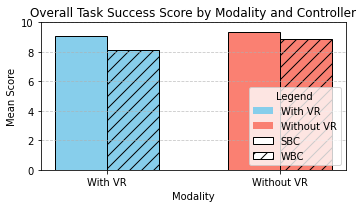

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Compute the overall task success by taking the mean across all tasks for each participant
df_overall_success = df_plot.groupby(["Modality", "Controller"])["Success Score"].mean().reset_index()

# Replace values for consistency
df_overall_success["Modality"] = df_overall_success["Modality"].replace({"WITH-VR": "With VR", "NO-VR": "Without VR"})
df_overall_success["Controller"] = df_overall_success["Controller"].replace({"Chiron": "SBC"})

# Create a new column for hue
df_overall_success["Hue"] = df_overall_success["Modality"] + " - " + df_overall_success["Controller"]

# Plot the overall task success mean by Controller and Modality
plt.figure(figsize=(5, 3))

# Define colors for With VR and Without VR
color_palette = {"With VR": "skyblue", "Without VR": "salmon"}

# Define hatches for SBC and WBC
hatch_patterns = {"SBC": "", "WBC": "//"}

# Define bar width and x positions
bar_width = 0.3
x_positions = {"With VR": 0, "Without VR": 1}
offsets = {"With VR - SBC": -bar_width / 2, "With VR - WBC": bar_width / 2, 
           "Without VR - SBC": -bar_width / 2, "Without VR - WBC": bar_width / 2}

bars = []
for hue in df_overall_success["Hue"].unique():
    modality, controller = hue.split(" - ")  # Extract modality and controller
    subset = df_overall_success[df_overall_success["Hue"] == hue]

    # Adjust x positions for better spacing
    x_val = x_positions[subset["Modality"].values[0]] + offsets[hue]

    bar = plt.bar(
        x_val, subset["Success Score"].values[0], width=bar_width, color=color_palette[subset["Modality"].values[0]],
        edgecolor="black", label=hue if hue not in [b.get_label() for b in bars] else "", hatch=hatch_patterns[controller]
    )
    bars.append(bar[0])

# Adjust the legend with both color and hatch pattern
handles = [
    mpatches.Patch(facecolor="skyblue", label="With VR"),
    mpatches.Patch(facecolor="salmon", label="Without VR"),
    mpatches.Patch(facecolor="white", edgecolor="black", hatch="", label="SBC"),
    mpatches.Patch(facecolor="white", edgecolor="black", hatch="//", label="WBC"),
]

plt.xticks(ticks=[0, 1], labels=["With VR", "Without VR"])
plt.ylim(0, 10)
plt.title("Overall Task Success Score by Modality and Controller")
plt.xlabel("Modality")
plt.ylabel("Mean Score")

# Adjust the legend with both color and hatch pattern
plt.legend(handles=handles, title="Legend", loc="lower right")

# Show the plot
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("overall_performance_means.pdf", format='pdf')
plt.show()
